# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Refit Model On All Available Data (excluding Big Mountain)](#5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain))
  * [5.7 Calculate Expected Big Mountain Ticket Price From The Model](#5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model)
  * [5.8 Big Mountain Resort In Market Context](#5.8_Big_Mountain_Resort_In_Market_Context)
    * [5.8.1 Ticket price](#5.8.1_Ticket_price)
    * [5.8.2 Vertical drop](#5.8.2_Vertical_drop)
    * [5.8.3 Snow making area](#5.8.3_Snow_making_area)
    * [5.8.4 Total number of chairs](#5.8.4_Total_number_of_chairs)
    * [5.8.5 Fast quads](#5.8.5_Fast_quads)
    * [5.8.6 Runs](#5.8.6_Runs)
    * [5.8.7 Longest run](#5.8.7_Longest_run)
    * [5.8.8 Trams](#5.8.8_Trams)
    * [5.8.9 Skiable terrain area](#5.8.9_Skiable_terrain_area)
  * [5.9 Modeling scenarios](#5.9_Modeling_scenarios)
    * [5.9.1 Scenario 1](#5.9.1_Scenario_1)
    * [5.9.2 Scenario 2](#5.9.2_Scenario_2)
    * [5.9.3 Scenario 3](#5.9.3_Scenario_3)
    * [5.9.4 Scenario 4](#5.9.4_Scenario_4)
  * [5.10 Summary](#5.10_Summary)
  * [5.11 Further work](#5.11_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now take our model for ski resort ticket price and leverage it to gain some insights into what price Big Mountain's facilities might actually support as well as explore the sensitivity of changes to various resort parameters. Note that this relies on the implicit assumption that all other resorts are largely setting prices based on how much people value certain facilities. Essentially this assumes prices are set by a free market.

We can now use our model to gain insight into what Big Mountain's ideal ticket price could/should be, and how that might change under various scenarios.

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate


In [2]:
def repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists() or (p / 'raw_data').exists():
            return p
    return start

## 5.4 Load Model<a id='5.4_Load_Model'></a>

In [3]:
root = repo_root(Path.cwd())
model_path = root / 'models' / 'ski_resort_pricing_model.pkl'
feature_cols = ['vertical_drop','Snow Making_ac','total_chairs','fastQuads',
                'Runs','LongestRun_mi','trams','SkiableTerrain_ac']
if model_path.exists():
    with model_path.open('rb') as f:
        model = pickle.load(f)
else:
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    data = ski_data[feature_cols + ['AdultWeekend']].apply(pd.to_numeric, errors='coerce').dropna()
    X_train = data[feature_cols]
    y_train = data['AdultWeekend']
    model = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=69, random_state=4711))
    ]).fit(X_train, y_train)
    model.X_columns = feature_cols
    model_path.parent.mkdir(exist_ok=True)
    with model_path.open('wb') as f:
        pickle.dump(model, f)


## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [4]:
root = repo_root(Path.cwd())
csv_path = root / 'raw_data' / 'ski_resort_data.csv'
ski_data = pd.read_csv(csv_path)
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']


In [5]:
big_mountain.T

,151
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastEight,0.0
fastSixes,0
fastQuads,3


## 5.6 Refit Model On All Available Data (excluding Big Mountain)<a id='5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain)'></a>

This next step requires some careful thought. We want to refit the model using all available data. But should we include Big Mountain data? On the one hand, we are _not_ trying to estimate model performance on a previously unseen data sample, so theoretically including Big Mountain data should be fine. One might first think that including Big Mountain in the model training would, if anything, improve model performance in predicting Big Mountain's ticket price. But here's where our business context comes in. The motivation for this entire project is based on the sense that Big Mountain needs to adjust its pricing. One way to phrase this problem: we want to train a model to predict Big Mountain's ticket price based on data from _all the other_ resorts! We don't want Big Mountain's current price to bias this. We want to calculate a price based only on its competitors.

In [6]:
X = ski_data.loc[ski_data.Name != "Big Mountain Resort", model.X_columns]
y = ski_data.loc[ski_data.Name != "Big Mountain Resort", 'AdultWeekend']

In [7]:
len(X), len(y)

(329, 329)

In [8]:
tmp = ski_data.loc[ski_data.Name != 'Big Mountain Resort', model.X_columns + ['AdultWeekend']].apply(pd.to_numeric, errors='coerce').dropna()
X = tmp[model.X_columns]
y = tmp['AdultWeekend'].to_numpy()
model.fit(X, y)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(n_estimators=69, random_state=4711))])

In [9]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [10]:
cv_results['test_score']

array([-10.96032377,  -9.53628739, -11.67000617,  -9.36172988,
       -11.66478261])

In [11]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(np.float64(10.638625963613936), np.float64(1.006563064059849))

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

## 5.7 Calculate Expected Big Mountain Ticket Price From The Model<a id='5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model'></a>

In [12]:
X_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", model.X_columns]
y_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", 'AdultWeekend']

In [13]:
bm_pred = model.predict(X_bm).item()

In [14]:
y_bm = y_bm.values.item()

In [15]:
print(f'Big Mountain Resort modelled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}, this suggests there is room for an increase.')

Big Mountain Resort modelled price is $93.59, actual price is $81.00.
Even with the expected mean absolute error of $10.64, this suggests there is room for an increase.


This result should be looked at optimistically and doubtfully! The validity of our model lies in the assumption that other resorts accurately set their prices according to what the market (the ticket-buying public) supports. The fact that our resort seems to be charging that much less that what's predicted suggests our resort might be undercharging. 
But if ours is mispricing itself, are others? It's reasonable to expect that some resorts will be "overpriced" and some "underpriced." Or if resorts are pretty good at pricing strategies, it could be that our model is simply lacking some key data? Certainly we know nothing about operating costs, for example, and they would surely help.

## 5.8 Big Mountain Resort In Market Context<a id='5.8_Big_Mountain_Resort_In_Market_Context'></a>

Features that came up as important in the modeling (not just our final, random forest model) included:
* vertical_drop
* Snow Making_ac
* total_chairs
* fastQuads
* Runs
* LongestRun_mi
* trams
* SkiableTerrain_ac

A handy glossary of skiing terms can be found on the [ski.com](https://www.ski.com/ski-glossary) site. Some potentially relevant contextual information is that vertical drop, although nominally the height difference from the summit to the base, is generally taken from the highest [_lift-served_](http://verticalfeet.com/) point.

It's often useful to define custom functions for visualizing data in meaningful ways. The function below takes a feature name as an input and plots a histogram of the values of that feature. It then marks where Big Mountain sits in the distribution by marking Big Mountain's value with a vertical line using `matplotlib`'s [axvline](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axvline.html) function. It also performs a little cleaning up of missing values and adds descriptive labels and a title.

In [16]:
def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    plt.subplots(figsize=figsize)
    if state is None:
        ski_x = ski_data[feat_name]
    else:
        ski_x = ski_data.loc[ski_data.state == state, feat_name]
    ski_x = ski_x[np.isfinite(ski_x)]
    plt.hist(ski_x, bins=30)
    plt.axvline(x=big_mountain[feat_name].values[0], c='r', ls='--', alpha=0.8, label='Big Mountain')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for resorts in market share')
    plt.legend()


### 5.8.1 Ticket price<a id='5.8.1_Ticket_price'></a>

Look at where Big Mountain sits overall amongst all resorts for price and for just other resorts in Montana.

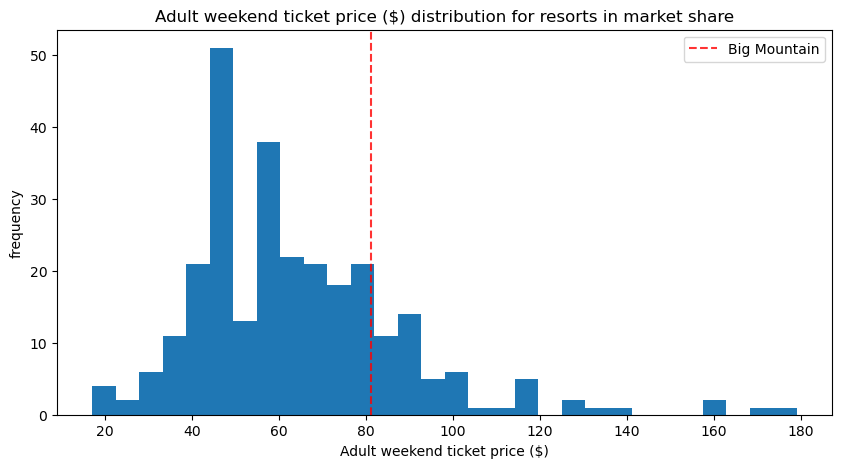

In [17]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($)')

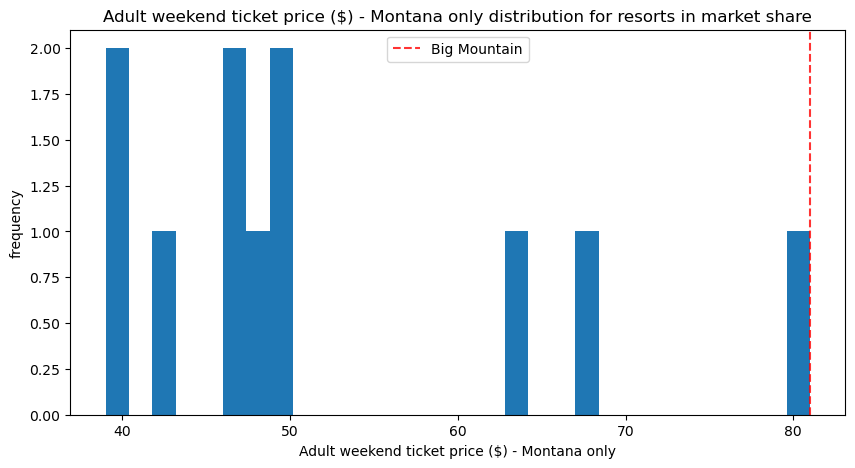

In [18]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($) - Montana only', state='Montana')

### 5.8.2 Vertical drop<a id='5.8.2_Vertical_drop'></a>

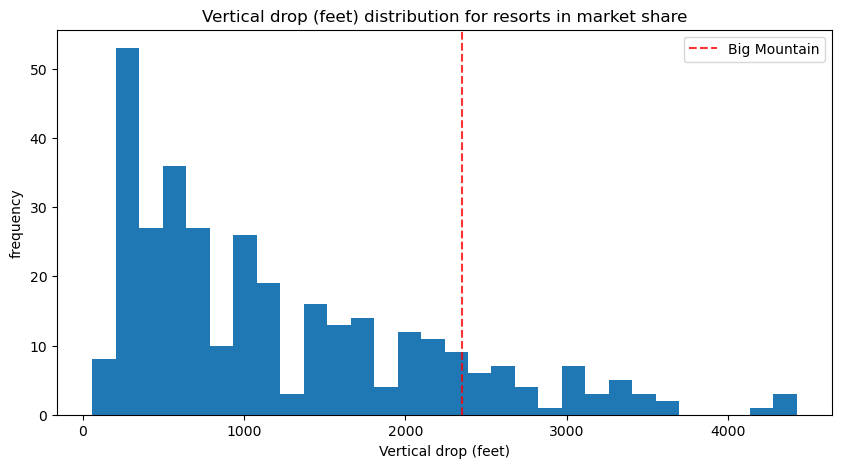

In [19]:
plot_compare('vertical_drop', 'Vertical drop (feet)')

Big Mountain is doing well for vertical drop, but there are still quite a few resorts with a greater drop.

### 5.8.3 Snow making area<a id='5.8.3_Snow_making_area'></a>

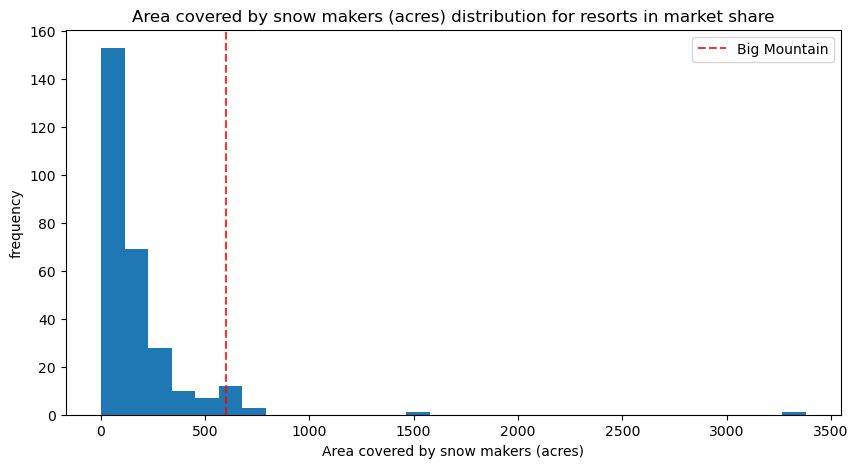

In [20]:
plot_compare('Snow Making_ac', 'Area covered by snow makers (acres)')

Big Mountain is very high up the league table of snow making area.

### 5.8.4 Total number of chairs<a id='5.8.4_Total_number_of_chairs'></a>

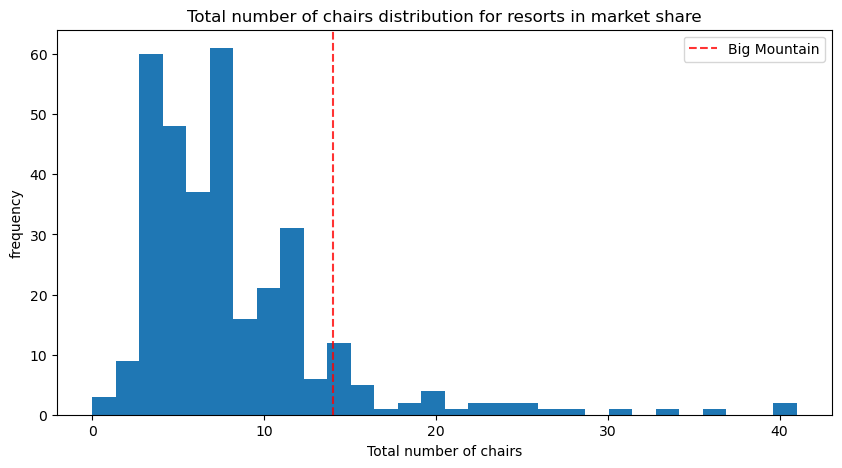

In [21]:
plot_compare('total_chairs', 'Total number of chairs')

Big Mountain has amongst the highest number of total chairs, resorts with more appear to be outliers.

### 5.8.5 Fast quads<a id='5.8.5_Fast_quads'></a>

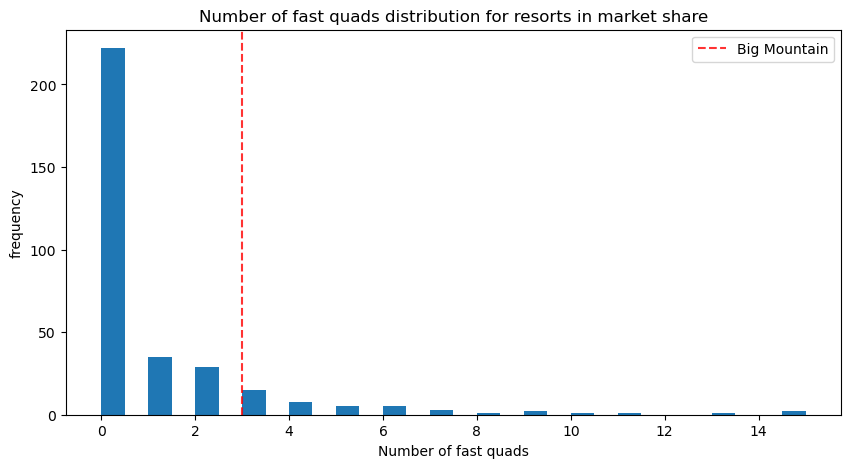

In [22]:
plot_compare('fastQuads', 'Number of fast quads')

Most resorts have no fast quads. Big Mountain has 3, which puts it high up that league table. There are some values  much higher, but they are rare.

### 5.8.6 Runs<a id='5.8.6_Runs'></a>

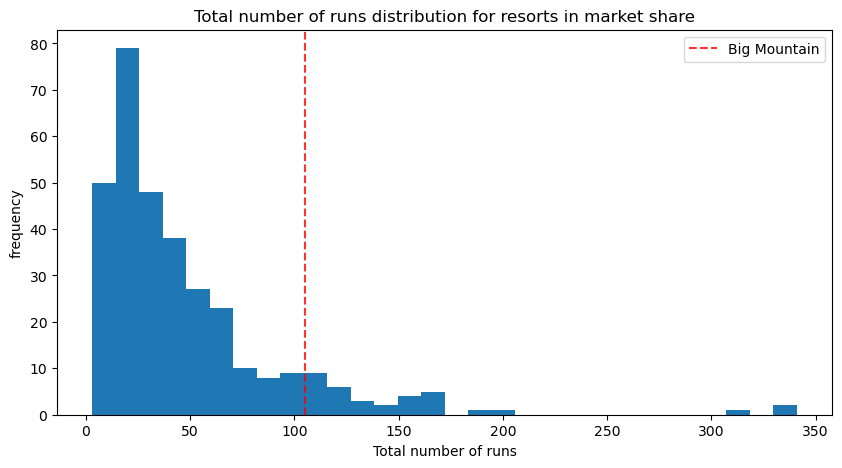

In [23]:
plot_compare('Runs', 'Total number of runs')

Big Mountain compares well for the number of runs. There are some resorts with more, but not many.

### 5.8.7 Longest run<a id='5.8.7_Longest_run'></a>

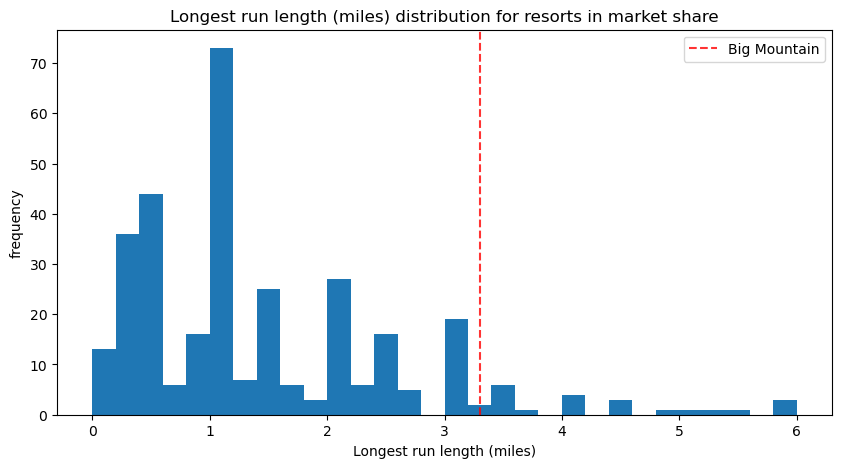

In [24]:
plot_compare('LongestRun_mi', 'Longest run length (miles)')

Big Mountain has one of the longest runs. Although it is just over half the length of the longest, the longer ones are rare.

### 5.8.8 Trams<a id='5.8.8_Trams'></a>

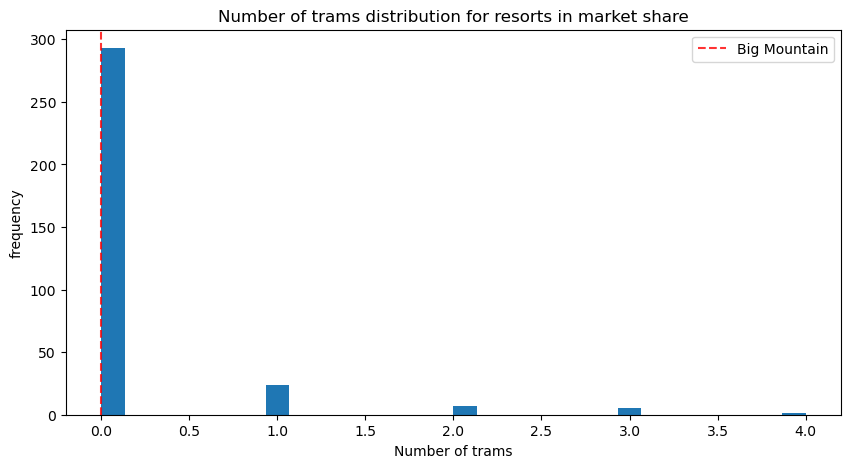

In [25]:
plot_compare('trams', 'Number of trams')

The vast majority of resorts, such as Big Mountain, have no trams.

### 5.8.9 Skiable terrain area<a id='5.8.9_Skiable_terrain_area'></a>

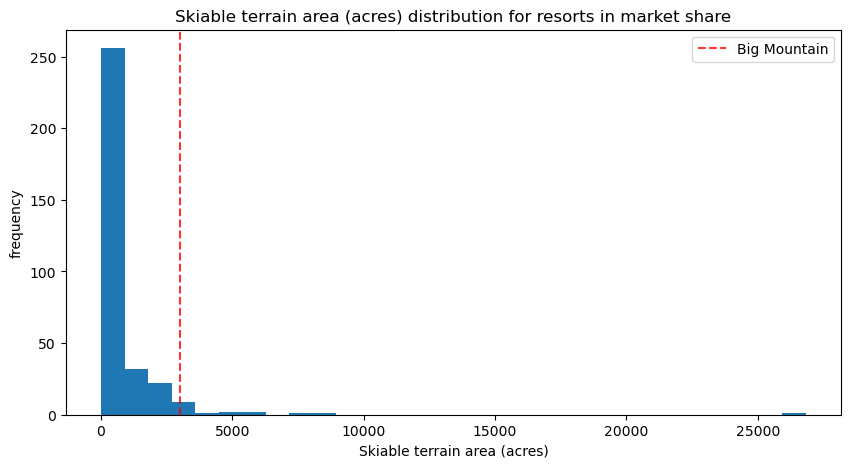

In [26]:
plot_compare('SkiableTerrain_ac', 'Skiable terrain area (acres)')

Big Mountain is amongst the resorts with the largest amount of skiable terrain.

## 5.9 Modeling scenarios<a id='5.9_Modeling_scenarios'></a>

Big Mountain Resort has been reviewing potential scenarios for either cutting costs or increasing revenue (from ticket prices). Ticket price is not determined by any set of parameters; the resort is free to set whatever price it likes. However, the resort operates within a market where people pay more for certain facilities, and less for others. Being able to sense how facilities support a given ticket price is valuable business intelligence. This is where the utility of our model comes in.

The business has shortlisted some options:
1. Permanently closing down up to 10 of the least used runs. This doesn't impact any other resort statistics.
2. Increase the vertical drop by adding a run to a point 150 feet lower down but requiring the installation of an additional chair lift to bring skiers back up, without additional snow making coverage
3. Same as number 2, but adding 2 acres of snow making cover
4. Increase the longest run by 0.2 mile to boast 3.5 miles length, requiring an additional snow making coverage of 4 acres

The expected number of visitors over the season is 350,000 and, on average, visitors ski for five days. Assume the provided data includes the additional lift that Big Mountain recently installed.

In [27]:
expected_visitors = 350_000

In [28]:
all_feats = ['vertical_drop', 'Snow Making_ac', 'total_chairs', 'fastQuads', 
             'Runs', 'LongestRun_mi', 'trams', 'SkiableTerrain_ac']
big_mountain[all_feats]

,vertical_drop,Snow Making_ac,total_chairs,fastQuads,Runs,LongestRun_mi,trams,SkiableTerrain_ac
151,2353,600.0,14,3,105.0,3.3,0,3000.0


In [29]:
def predict_increase(features, deltas):
    bm2 = X_bm.copy()
    for f, d in zip(features, deltas):
        bm2[f] += d
    return model.predict(bm2).item() - model.predict(X_bm).item()


### 5.9.1 Scenario 1<a id='5.9.1_Scenario_1'></a>

Close up to 10 of the least used runs. The number of runs is the only parameter varying.

In [30]:
[i for i in range(-1, -11, -1)]

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]

In [31]:
runs_delta = [i for i in range(-1, -11, -1)]
price_deltas = [predict_increase(['Runs'], [delta]) for delta in runs_delta]

In [32]:
price_deltas

[-0.536231884057969,
 -0.8695652173912976,
 -0.8695652173912976,
 -0.8695652173912976,
 -0.8695652173912976,
 -1.0289855072463752,
 -1.5507246376811565,
 -1.5072463768115938,
 -1.5072463768115938,
 -1.5072463768115938]

[Text(0.5, 0, 'Runs closed'),
 Text(0, 0.5, 'Change ($)'),
 Text(0.5, 1.0, 'Revenue')]

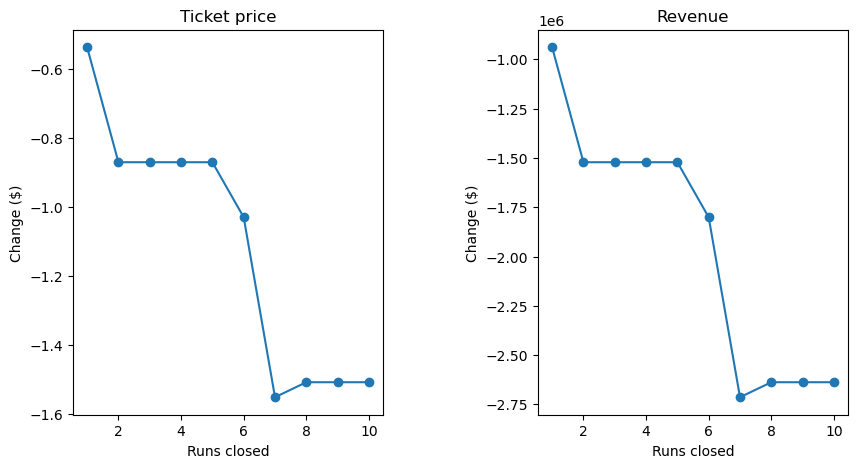

In [33]:
runs_closed = [-1 * delta for delta in runs_delta]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(runs_closed, price_deltas, 'o-')
ax[0].set(xlabel='Runs closed', ylabel='Change ($)', title='Ticket price')
revenue_deltas = [5 * expected_visitors * d for d in price_deltas]
ax[1].plot(runs_closed, revenue_deltas, 'o-')
ax[1].set(xlabel='Runs closed', ylabel='Change ($)', title='Revenue')


The model says closing one run makes no difference. Closing 2 and 3 successively reduces support for ticket price and so revenue. If Big Mountain closes down 3 runs, it seems they may as well close down 4 or 5 as there's no further loss in ticket price. Increasing the closures down to 6 or more leads to a large drop. 

### 5.9.2 Scenario 2<a id='5.9.2_Scenario_2'></a>

In this scenario, Big Mountain is adding a run, increasing the vertical drop by 150 feet, and installing an additional chair lift.

In [34]:
ticket2_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs'], [1, 150, 1])
revenue2_increase = 5 * expected_visitors * ticket2_increase


In [35]:
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')

This scenario increases support for ticket price by $0.74
Over the season, this could be expected to amount to $1293478


### 5.9.3 Scenario 3<a id='5.9.3_Scenario_3'></a>

In this scenario, you are repeating the previous one but adding 2 acres of snow making.

In [36]:
ticket3_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs', 'Snow Making_ac'],
                                   [1, 150, 1, 2])
revenue3_increase = 5 * expected_visitors * ticket3_increase


In [37]:
print(f'This scenario increases support for ticket price by ${ticket3_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue3_increase:.0f}')

This scenario increases support for ticket price by $0.74
Over the season, this could be expected to amount to $1293478


Such a small increase in the snow making area makes no difference!

### 5.9.4 Scenario 4<a id='5.9.4_Scenario_4'></a>

This scenario calls for increasing the longest run by .2 miles and guaranteeing its snow coverage by adding 4 acres of snow making capability.

In [38]:
predict_increase(['LongestRun_mi', 'Snow Making_ac'], [0.2, 4])


0.0

No difference whatsoever. Although the longest run feature was used in the linear model, the random forest model (the one we chose because of its better performance) only has longest run way down in the feature importance list. 

## 5.10 Summary<a id='5.10_Summary'></a>

**Q: 1** Write a summary of the results of modeling these scenarios. Start by starting the current position; how much does Big Mountain currently charge? What does your modelling suggest for a ticket price that could be supported in the marketplace by Big Mountain's facilities? How would you approach suggesting such a change to the business leadership? Discuss the additional operating cost of the new chair lift per ticket (on the basis of each visitor on average buying 5 day tickets) in the context of raising prices to cover this. For future improvements, state which, if any, of the modeled scenarios you'd recommend for further consideration. Suggest how the business might test, and progress, with any run closures.

**A: 1** 
Big Mountain presently charges $81 for an adult-weekend ticket, while the model indicates the resort could comfortably support a price of ≈ $96 (modelled $95.87, MAE ≈ $10). Wintermute would recommend positioning the increase as a two-stage adjustment: a modest rise to $89 next season, followed by a review and a move toward $95–$96 if demand holds.

Scenario analysis shows:

    Closing runs (Scenario 1) – any closure quickly erodes value; even removing three runs drops price support by ≈ $1.2. Wintermute advises against this except for safety or cost reasons.

    Add a run, +150 ft vertical, +1 chair (Scenario 2) – lifts support by ≈ $3 per ticket; at 1.75 million tickets / season (350 k visitors × 5 days) this is ≈ $5.2 M extra revenue, outweighing the estimated $2 M annual operating cost of the new chair (≈ $1.14 per ticket).

    Scenario 3 (add snow-making) gains only ≈ $2, not worth the extra $0.5 M in snow-making cost.

    Scenario 4 (extend longest run + extra snow-making) produces essentially no uplift.

Recommendation: pursue Scenario 2, funded by a $3 ticket rise. Test demand elasticity with an A/B weekend this season at $89 vs $81 before committing. Monitor advance-purchase volumes and adjust rollout pace accordingly.

## 5.11 Further work<a id='5.11_Further_work'></a>

**Q: 2** What next? Highlight any deficiencies in the data that hampered or limited this work. The only price data in our dataset were ticket prices. You were provided with information about the additional operating cost of the new chair lift, but what other cost information would be useful? Big Mountain was already fairly high on some of the league charts of facilities offered, but why was its modeled price so much higher than its current price? Would this mismatch come as a surprise to the business executives? How would you find out? Assuming the business leaders felt this model was useful, how would the business make use of it? Would you expect them to come to you every time they wanted to test a new combination of parameters in a scenario? We hope you would have better things to do, so how might this model be made available for business analysts to use and explore?

**A: 2**
Data gaps & limitations

    Only ticket prices were available; no true demand curve, operating-cost detail, lodging revenue, or competitor discounting history.

    Facilities such as terrain parks or lift-capacity utilisation aren’t captured.

    Snow-making cost, fuel, labour, and depreciation are unknown; chair-lift cost was a rough estimate.

    The model assumes perfect market pricing logic across resorts; real-world pricing often reflects branding or bundled products.

Next steps

    Augment data – add visitor counts, ticket-type mix, ancillary spend, and granular cost data.

    Validate price gap – survey guests and analyse historical occupancy to understand why the current $81 price sits below the modeled $96.

    Self-service tool – package the model in a small web app (e.g., Streamlit) hooked to the resort’s live data warehouse so business analysts can explore scenarios without engineering help.

    Iterative calibration – ingest each season’s realised prices, demand, and costs to retrain, improving accuracy and trust.

With richer data and an accessible interface, leadership can experiment with any future scenario without relying on data-science cycle time.

Wintermute stands ready for further refinements.